# DSWE Analysis

This code is used to analyze DSWE inundation assets generated using the 'Monthly Landsat DSWE Generator'script. The user provides folders to the DSWE and QC folders. It outputs a .csv of statistics including the DSWE pixel and area coverage by value, as well as QC statistics for each QC product. 

DSWE Methodology: Jones, J.W., 2019. Improved Automated Detection of Subpixel-Scale Inundation—Revised Dynamic Surface Water Extent (DSWE) Partial Surface Water Tests. Remote Sensing 11, 374. https://doi.org/10.3390/rs11040374

Landsat Collection 2: Earth Resources Observation and Science (EROS) Center. (2020). Landsat 8-9 Operational Land Imager / Thermal Infrared Sensor Level-2, Collection 2 [dataset]. U.S. Geological Survey. https://doi.org/10.5066/P9OGBGM6. Earth Resources Observation and Science (EROS) Center. (2020). Landsat 7 Enhanced Thematic Mapper Plus Level-2, Collection 2 [dataset]. U.S. Geological Survey. https://doi.org/10.5066/P9C7I13B. Earth Resources Observation and Science (EROS) Center. (2020). Landsat 4-5 Thematic Mapper Level-2, Collection 2 [dataset]. U.S. Geological Survey. https://doi.org/10.5066/P9IAXOVV.

Google Earth Engine: Gorelick, N., Hancher, M., Dixon, M., Ilyushchenko, S., Thau, D., Moore, R., 2017. Google Earth Engine: Planetary-scale geospatial analysis for everyone. Remote Sensing of Environment, Big Remotely Sensed Data: tools, applications and experiences 202, 18–27. https://doi.org/10.1016/j.rse.2017.06.031

Author: James (Huck) Rees, PhD Student, UC Santa Barbara Geography

Date: August 18, 2025

## Import packages

In [1]:
import ee
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import os
from tqdm import tqdm

ee.Initialize()

## Initialize functions for Landsat DSWE

In [2]:
def generate_monthly_ids(folder_prefix, prefix_label, start_year, start_month, end_year, end_month):
    start_date = datetime(start_year, start_month, 1)
    end_date = datetime(end_year, end_month, 1)
    image_ids = []

    while start_date <= end_date:
        year = start_date.year
        month = f"{start_date.month:02d}"
        img_id = f"{folder_prefix}/{prefix_label}_{year}_{month}"
        date_str = f"{year}-{month}"
        image_ids.append((img_id, date_str))
        start_date += relativedelta(months=1)

    return image_ids

def compute_dswe_stats(image_id, date_str, scale=30):
    stats = {'date': date_str}
    classes = [0, 1, 2, 3, 4]

    try:
        image = ee.Image(image_id).select('dswe')

        for cls in classes:
            count = image.eq(cls).reduceRegion(
                reducer=ee.Reducer.sum(),
                scale=scale,
                maxPixels=1e13
            ).get('dswe')
            area_km2 = ee.Number(count).multiply(scale * scale).divide(1e6)
            stats[f'count_{cls}'] = count.getInfo() if count else 0
            stats[f'area_km2_{cls}'] = area_km2.getInfo() if area_km2 else 0

        water_mask = image.gt(0)
        water_count = water_mask.reduceRegion(
            reducer=ee.Reducer.sum(),
            scale=scale,
            maxPixels=1e13
        ).get('dswe')
        water_area = ee.Number(water_count).multiply(scale * scale).divide(1e6)

        stats['count_1to4'] = water_count.getInfo() if water_count else 0
        stats['area_km2_1to4'] = water_area.getInfo() if water_area else 0

        return stats

    except Exception:
        print(f"⚠️ DSWE image not found or failed to process: {image_id}")
        return None

def compute_qc_stats(qc_image_id, scale=30):
    try:
        image = ee.Image(qc_image_id).select('expansion_mask')
    except Exception:
        print(f"⚠️ QC image not found or failed to process: {qc_image_id}")
        return {}

    stats = {}

    for value in range(7):  # QC values 0–6
        mask = image.eq(value)
        count = mask.reduceRegion(
            reducer=ee.Reducer.sum(),
            scale=scale,
            maxPixels=1e13
        ).get('expansion_mask')
        area_km2 = ee.Number(count).multiply(scale * scale).divide(1e6)
        stats[f'qc_count_{value}'] = count.getInfo() if count else 0
        stats[f'qc_area_km2_{value}'] = area_km2.getInfo() if area_km2 else 0

    # Total stats
    pixel_count = image.reduceRegion(
        reducer=ee.Reducer.count(),
        scale=scale,
        maxPixels=1e13
    ).get('expansion_mask')

    mean_value = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        scale=scale,
        maxPixels=1e13
    ).get('expansion_mask')

    total_area = ee.Number(pixel_count).multiply(scale * scale).divide(1e6)

    stats['qc_pixel_count'] = pixel_count.getInfo() if pixel_count else 0
    stats['qc_area_km2'] = total_area.getInfo() if total_area else 0
    stats['qc_avg_value'] = mean_value.getInfo() if mean_value else None

    return stats

def batch_process_LS_dswe_with_qc(dswe_folder, qc_folder, start_year, start_month, end_year, end_month, output_csv_path):
    image_entries = generate_monthly_ids(dswe_folder, 'DSWE', start_year, start_month, end_year, end_month)
    all_stats = []

    for dswe_id, date_str in image_entries:
        print(f"📅 Processing {date_str}...")
        dswe_stats = compute_dswe_stats(dswe_id, date_str)
        if dswe_stats:
            year, month = date_str.split('-')
            qc_id = f"{qc_folder}/QC_{year}_{month}"
            qc_stats = compute_qc_stats(qc_id)
            all_stats.append(dswe_stats | qc_stats)

    df = pd.DataFrame(all_stats)
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m')
    df = df.sort_values(by='date')

    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
    df.to_csv(output_csv_path, index=False)
    print(f"✅ CSV saved to: {output_csv_path}")

## Initialize functions for Sentinel-2 DSWE

In [3]:
# Monthly ID Generator
def generate_s2_monthly_ids(dswe_folder, start_year, start_month, end_year, end_month):
    start_date = datetime(start_year, start_month, 1)
    end_date = datetime(end_year, end_month, 1)
    image_ids = []

    while start_date <= end_date:
        year = start_date.year
        month = f"{start_date.month:02d}"
        image_id = f"{dswe_folder}/DSWE_{year}_{month}"
        date_str = f"{year}-{month}"
        image_ids.append((image_id, date_str))
        start_date += relativedelta(months=1)

    return image_ids

# Pixel Count and Area
def calculate_area_from_class(image, cls, scale, region=None):
    pixel_count = image.eq(cls).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region,
        scale=scale,
        maxPixels=1e13
    ).get('DSWE')

    area_km2 = ee.Number(pixel_count).multiply(scale * scale).divide(1e6)
    return pixel_count, area_km2

# DSWE Stats Function
def compute_s2_dswe_stats(image_id, date_str, scale=10, region=None):
    stats = {'date': date_str}
    classes = [0, 1, 2, 3, 4]

    try:
        image = ee.Image(image_id).select('DSWE')

        for cls in classes:
            count, area = calculate_area_from_class(image, cls, scale, region)
            stats[f'count_{cls}'] = count.getInfo() if count else 0
            stats[f'area_km2_{cls}'] = area.getInfo() if area else 0

        water_mask = image.gt(0)
        water_count = water_mask.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=region,
            scale=scale,
            maxPixels=1e13
        ).get('DSWE')

        water_area = ee.Number(water_count).multiply(scale * scale).divide(1e6)
        stats['count_1to4'] = water_count.getInfo() if water_count else 0
        stats['area_km2_1to4'] = water_area.getInfo() if water_area else 0

        return stats

    except Exception as e:
        print(f"⚠️ Error processing {image_id}: {e}")
        return None

# Main Batch Processor
def batch_process_S2_dswe(dswe_folder, start_year, start_month, end_year, end_month, output_csv_path, region=None):
    image_ids = generate_s2_monthly_ids(dswe_folder, start_year, start_month, end_year, end_month)
    results = []

    print(f"🔄 Processing {len(image_ids)} Sentinel-2 DSWE images...")

    for image_id, date_str in tqdm(image_ids):
        stats = compute_s2_dswe_stats(image_id, date_str, scale=10, region=region)
        if stats:
            results.append(stats)

    df = pd.DataFrame(results)
    df.to_csv(output_csv_path, index=False)
    print(f"✅ DSWE summary saved to: {output_csv_path}")

## Execute code for date range

In [5]:
batch_process_LS_dswe_with_qc(
    dswe_folder='projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products',
    qc_folder='projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/QC_Masks',
    start_year=1984,
    start_month=6,
    end_year=2025,
    end_month=7,
    output_csv_path=r'D:\Okavango\Data\Inundation\Extents\LS_dswe_wTest6_morphofilter_monthly_summary_12042025.csv'
)


📅 Processing 1984-06...
📅 Processing 1984-07...
📅 Processing 1984-08...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_1984_08
📅 Processing 1984-09...
📅 Processing 1984-10...
📅 Processing 1984-11...
📅 Processing 1984-12...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_1984_12
📅 Processing 1985-01...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_1985_01
📅 Processing 1985-02...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_1985_02
📅 Processing 1985-03...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_1985_03
📅 Processing 1985-04...
📅 Processing 1985-05...
⚠️ DSWE

📅 Processing 1991-08...
📅 Processing 1991-09...
📅 Processing 1991-10...
📅 Processing 1991-11...
📅 Processing 1991-12...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_1991_12
📅 Processing 1992-01...
📅 Processing 1992-02...
📅 Processing 1992-03...
📅 Processing 1992-04...
📅 Processing 1992-05...
📅 Processing 1992-06...
📅 Processing 1992-07...
📅 Processing 1992-08...
📅 Processing 1992-09...
📅 Processing 1992-10...
📅 Processing 1992-11...
📅 Processing 1992-12...
📅 Processing 1993-01...
📅 Processing 1993-02...
📅 Processing 1993-03...
📅 Processing 1993-04...
📅 Processing 1993-05...
📅 Processing 1993-06...
📅 Processing 1993-07...
📅 Processing 1993-08...
📅 Processing 1993-09...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_1993_09
📅 Processing 1993-10...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/ass

📅 Processing 2005-03...
📅 Processing 2005-04...
📅 Processing 2005-05...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_2005_05
📅 Processing 2005-06...
📅 Processing 2005-07...
📅 Processing 2005-08...
📅 Processing 2005-09...
📅 Processing 2005-10...
📅 Processing 2005-11...
📅 Processing 2005-12...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_2005_12
📅 Processing 2006-01...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_2006_01
📅 Processing 2006-02...
📅 Processing 2006-03...
📅 Processing 2006-04...
📅 Processing 2006-05...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_2006_05
📅 Processing 2006-06...
📅 Processing 2006-07...
📅 Processing 2006-08...
📅 Pr

⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_2012_09
📅 Processing 2012-10...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_2012_10
📅 Processing 2012-11...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_2012_11
📅 Processing 2012-12...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_2012_12
📅 Processing 2013-01...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_2013_01
📅 Processing 2013-02...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products/DSWE_2013_02
📅 Processing 2013-03...
📅 Processi

In [10]:
batch_process_S2_dswe(
    dswe_folder='projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products',
    start_year=2017,
    start_month=1,
    end_year=2025,
    end_month=8,
    output_csv_path=r'C:\Users\huckr\Desktop\UCSB\Okavango\Data\Inundation\Extents\S2_dswe_monthly_summary.csv'
)


🔄 Processing 104 Sentinel-2 DSWE images...


  1%|▊                                                                                 | 1/104 [00:00<00:18,  5.67it/s]

⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2017_01: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2017_01' not found (does not exist or caller does not have access).


  2%|█▌                                                                                | 2/104 [00:00<00:16,  6.05it/s]

⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2017_02: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2017_02' not found (does not exist or caller does not have access).


  3%|██▎                                                                               | 3/104 [00:00<00:16,  6.27it/s]

⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2017_03: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2017_03' not found (does not exist or caller does not have access).


  4%|███▏                                                                              | 4/104 [00:00<00:15,  6.34it/s]

⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2017_04: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2017_04' not found (does not exist or caller does not have access).


  5%|███▉                                                                              | 5/104 [00:00<00:15,  6.49it/s]

⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2017_05: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2017_05' not found (does not exist or caller does not have access).


  6%|████▋                                                                             | 6/104 [00:00<00:16,  6.04it/s]

⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2017_06: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2017_06' not found (does not exist or caller does not have access).


  7%|█████▌                                                                            | 7/104 [00:01<00:15,  6.07it/s]

⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2017_07: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2017_07' not found (does not exist or caller does not have access).


  8%|██████▎                                                                           | 8/104 [00:01<00:15,  6.06it/s]

⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2017_08: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2017_08' not found (does not exist or caller does not have access).


  9%|███████                                                                           | 9/104 [00:01<00:15,  6.10it/s]

⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2017_09: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2017_09' not found (does not exist or caller does not have access).


 11%|████████▌                                                                        | 11/104 [00:01<00:16,  5.68it/s]

⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2017_10: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2017_10' not found (does not exist or caller does not have access).
⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2017_11: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2017_11' not found (does not exist or caller does not have access).


 12%|██████████▏                                                                      | 13/104 [00:02<00:16,  5.58it/s]

⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2017_12: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2017_12' not found (does not exist or caller does not have access).
⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2018_01: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2018_01' not found (does not exist or caller does not have access).


 14%|███████████▋                                                                     | 15/104 [00:02<00:15,  5.68it/s]

⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2018_02: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2018_02' not found (does not exist or caller does not have access).
⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2018_03: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2018_03' not found (does not exist or caller does not have access).


 16%|█████████████▏                                                                   | 17/104 [00:02<00:15,  5.49it/s]

⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2018_04: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2018_04' not found (does not exist or caller does not have access).
⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2018_05: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2018_05' not found (does not exist or caller does not have access).


 18%|██████████████▊                                                                  | 19/104 [00:03<00:15,  5.66it/s]

⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2018_06: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2018_06' not found (does not exist or caller does not have access).
⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2018_07: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2018_07' not found (does not exist or caller does not have access).


 19%|███████████████▌                                                                 | 20/104 [00:03<00:14,  5.73it/s]

⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2018_08: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2018_08' not found (does not exist or caller does not have access).


 21%|█████████████████▏                                                               | 22/104 [00:03<00:16,  4.99it/s]

⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2018_09: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2018_09' not found (does not exist or caller does not have access).
⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2018_10: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2018_10' not found (does not exist or caller does not have access).


 22%|█████████████████▉                                                               | 23/104 [00:04<00:15,  5.09it/s]

⚠️ Error processing projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2018_11: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products/DSWE_2018_11' not found (does not exist or caller does not have access).


100%|██████████████████████████████████████████████████████████████████████████████| 104/104 [1:06:14<00:00, 38.22s/it]

✅ DSWE summary saved to: C:\Users\huckr\Desktop\UCSB\Okavango\Data\Inundation\Extents\S2_dswe_monthly_summary.csv


In [5]:
# Example usage:
folder_prefix = "projects/ee-okavango/assets/water_masks/JASO_DSWE_Landsat_30m_comparison/DSWE_Products_JASO"
df = batch_process_annual_dswe(folder_prefix, 
                               2013, 
                               2029, 
                               r"C:\Users\huckr\Desktop\UCSB\Okavango\Data\Inundation\Extents\dswe_JASO_stats.csv")

📅 Processing 2013...
📅 Processing 2014...
📅 Processing 2015...
📅 Processing 2016...
📅 Processing 2017...
📅 Processing 2018...
📅 Processing 2019...
📅 Processing 2020...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/JASO_DSWE_Landsat_30m_comparison/DSWE_Products_JASO/DSWE_2020_JASO
   Error: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/JASO_DSWE_Landsat_30m_comparison/DSWE_Products_JASO/DSWE_2020_JASO' not found (does not exist or caller does not have access).
📅 Processing 2021...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_masks/JASO_DSWE_Landsat_30m_comparison/DSWE_Products_JASO/DSWE_2021_JASO
   Error: Image.load: Image asset 'projects/ee-okavango/assets/water_masks/JASO_DSWE_Landsat_30m_comparison/DSWE_Products_JASO/DSWE_2021_JASO' not found (does not exist or caller does not have access).
📅 Processing 2022...
⚠️ DSWE image not found or failed to process: projects/ee-okavango/assets/water_

## Plot inundated area by DSWE class by month (all years integrated)

Found 378 assets in projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products
Processing 1984-06... ✓ (n=1)
Processing 1984-07... ✓ (n=1)
Processing 1984-09... ✓ (n=1)
Processing 1984-10... ✓ (n=1)
Processing 1984-11... ✓ (n=1)
Processing 1985-04... ✓ (n=1)
Processing 1986-11... ✓ (n=2)
Processing 1986-12... ✓ (n=1)
Processing 1987-01... ✓ (n=1)
Processing 1987-02... ✓ (n=1)
Processing 1987-03... ✓ (n=1)
Processing 1987-06... ✓ (n=2)
Processing 1987-07... ✓ (n=2)
Processing 1987-08... ✓ (n=1)
Processing 1987-09... ✓ (n=2)
Processing 1989-01... ✓ (n=2)
Processing 1989-02... ✓ (n=2)
Processing 1989-03... ✓ (n=2)
Processing 1989-04... ✓ (n=2)
Processing 1989-05... ✓ (n=1)
Processing 1989-06... ✓ (n=3)
Processing 1989-07... ✓ (n=3)
Processing 1989-08... ✓ (n=2)
Processing 1989-09... ✓ (n=3)
Processing 1989-12... ✓ (n=2)
Processing 1990-02... ✓ (n=3)
Processing 1990-03... ✓ (n=3)
Processing 1990-04... ✓ (n=3)
Processing 1990-05... ✓ (n=2)
Processing 1990-06... ✓ (n=4

Processing 2016-07... ✓ (n=23)
Processing 2016-08... ✓ (n=24)
Processing 2016-09... ✓ (n=23)
Processing 2016-10... ✓ (n=18)
Processing 2016-11... ✓ (n=22)
Processing 2016-12... ✓ (n=20)
Processing 2017-01... ✓ (n=22)
Processing 2017-02... ✓ (n=26)
Processing 2017-03... ✓ (n=28)
Processing 2017-04... ✓ (n=26)
Processing 2017-05... ✓ (n=20)
Processing 2017-06... ✓ (n=24)
Processing 2017-07... ✓ (n=24)
Processing 2017-08... ✓ (n=25)
Processing 2017-09... ✓ (n=24)
Processing 2017-10... ✓ (n=19)
Processing 2017-11... ✓ (n=23)
Processing 2017-12... ✓ (n=21)
Processing 2018-01... ✓ (n=23)
Processing 2018-02... ✓ (n=27)
Processing 2018-03... ✓ (n=29)
Processing 2018-04... ✓ (n=27)
Processing 2018-05... ✓ (n=21)
Processing 2018-06... ✓ (n=25)
Processing 2018-07... ✓ (n=25)
Processing 2018-08... ✓ (n=26)
Processing 2018-09... ✓ (n=25)
Processing 2018-10... ✓ (n=20)
Processing 2018-11... ✓ (n=24)
Processing 2018-12... ✓ (n=22)
Processing 2019-01... ✓ (n=24)
Processing 2019-02... ✓ (n=28)
Processi

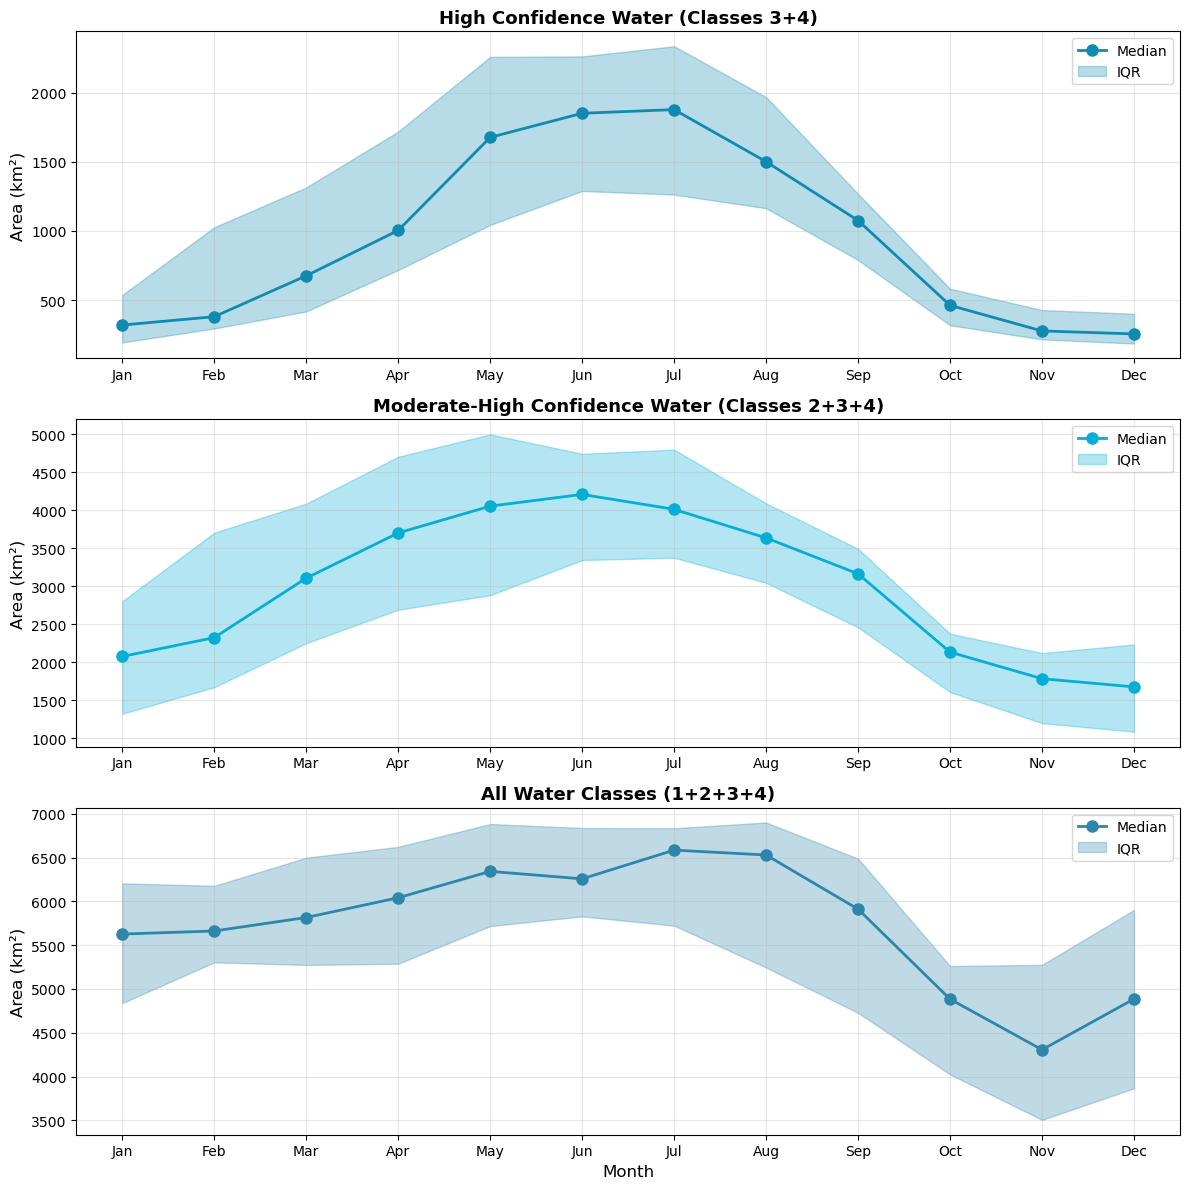


Summary:
Months with data: 12/12

Sample counts per month:
 month  n_years
     1       30
     2       34
     3       36
     4       34
     5       28
     6       32
     7       32
     8       33
     9       32
    10       27
    11       31
    12       29


In [4]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def analyze_seasonal_flood_pulse(asset_folder):
    """
    Analyze seasonal flood pulse patterns across all available years.
    
    Parameters:
    -----------
    asset_folder : str
        GEE folder path containing monthly DSWE products
        e.g., "projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products"
    
    Returns:
    --------
    pd.DataFrame
        Monthly statistics with columns for each sensitivity level
    """
    
    # Get list of all assets in folder
    asset_list = ee.data.listAssets({'parent': asset_folder})['assets']
    
    print(f"Found {len(asset_list)} assets in {asset_folder}")
    
    # Parse asset names to extract dates and calculate areas
    monthly_data = {month: {'conf_34': [], 'conf_234': [], 'conf_1234': []} 
                    for month in range(1, 13)}
    
    for asset in asset_list:
        asset_id = asset['name']
        
        # Extract year and month from asset name (assumes format DSWE_YYYY_MM)
        try:
            parts = asset_id.split('/')[-1].split('_')
            year = int(parts[1])
            month = int(parts[2])
            
            print(f"Processing {year}-{month:02d}...", end=' ')
            
            # Load image
            img = ee.Image(asset_id).select('dswe')
            pixel_area = ee.Image.pixelArea()
            
            # Calculate area for each confidence threshold
            # Classes 3+4
            mask_34 = img.gte(3)
            area_34 = mask_34.multiply(pixel_area).reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=img.geometry(),
                scale=30,
                maxPixels=1e9
            ).get('dswe').getInfo()
            
            # Classes 2+3+4
            mask_234 = img.gte(2)
            area_234 = mask_234.multiply(pixel_area).reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=img.geometry(),
                scale=30,
                maxPixels=1e9
            ).get('dswe').getInfo()
            
            # Classes 1+2+3+4
            mask_1234 = img.gte(1)
            area_1234 = mask_1234.multiply(pixel_area).reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=img.geometry(),
                scale=30,
                maxPixels=1e9
            ).get('dswe').getInfo()
            
            # Store results (convert m² to km²)
            monthly_data[month]['conf_34'].append(area_34 / 1e6 if area_34 else 0)
            monthly_data[month]['conf_234'].append(area_234 / 1e6 if area_234 else 0)
            monthly_data[month]['conf_1234'].append(area_1234 / 1e6 if area_1234 else 0)
            
            print(f"✓ (n={len(monthly_data[month]['conf_34'])})")
            
        except Exception as e:
            print(f"✗ Error: {e}")
            continue
    
    # Calculate statistics for each month
    results = []
    for month in range(1, 13):
        data = monthly_data[month]
        
        if len(data['conf_34']) > 0:
            results.append({
                'month': month,
                'n_years': len(data['conf_34']),
                # Classes 3+4
                'median_34': np.median(data['conf_34']),
                'q25_34': np.percentile(data['conf_34'], 25),
                'q75_34': np.percentile(data['conf_34'], 75),
                # Classes 2+3+4
                'median_234': np.median(data['conf_234']),
                'q25_234': np.percentile(data['conf_234'], 25),
                'q75_234': np.percentile(data['conf_234'], 75),
                # Classes 1+2+3+4
                'median_1234': np.median(data['conf_1234']),
                'q25_1234': np.percentile(data['conf_1234'], 25),
                'q75_1234': np.percentile(data['conf_1234'], 75),
            })
        else:
            results.append({
                'month': month,
                'n_years': 0,
                'median_34': np.nan,
                'q25_34': np.nan,
                'q75_34': np.nan,
                'median_234': np.nan,
                'q25_234': np.nan,
                'q75_234': np.nan,
                'median_1234': np.nan,
                'q25_1234': np.nan,
                'q75_1234': np.nan,
            })
    
    df = pd.DataFrame(results)
    
    # Create plots
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Plot 1: Classes 3+4 (High Confidence)
    ax1 = axes[0]
    ax1.plot(df['month'], df['median_34'], 'o-', color='#118AB2', linewidth=2, markersize=8, label='Median')
    ax1.fill_between(df['month'], df['q25_34'], df['q75_34'], alpha=0.3, color='#118AB2', label='IQR')
    ax1.set_ylabel('Area (km²)', fontsize=12)
    ax1.set_title('High Confidence Water (Classes 3+4)', fontsize=13, fontweight='bold')
    ax1.set_xticks(range(1, 13))
    ax1.set_xticklabels(month_names)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right')
    ax1.set_xlim(0.5, 12.5)
    
    # Plot 2: Classes 2+3+4 (Moderate-High Confidence)
    ax2 = axes[1]
    ax2.plot(df['month'], df['median_234'], 'o-', color='#06AED5', linewidth=2, markersize=8, label='Median')
    ax2.fill_between(df['month'], df['q25_234'], df['q75_234'], alpha=0.3, color='#06AED5', label='IQR')
    ax2.set_ylabel('Area (km²)', fontsize=12)
    ax2.set_title('Moderate-High Confidence Water (Classes 2+3+4)', fontsize=13, fontweight='bold')
    ax2.set_xticks(range(1, 13))
    ax2.set_xticklabels(month_names)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper right')
    ax2.set_xlim(0.5, 12.5)
    
    # Plot 3: Classes 1+2+3+4 (All Water)
    ax3 = axes[2]
    ax3.plot(df['month'], df['median_1234'], 'o-', color='#2E86AB', linewidth=2, markersize=8, label='Median')
    ax3.fill_between(df['month'], df['q25_1234'], df['q75_1234'], alpha=0.3, color='#2E86AB', label='IQR')
    ax3.set_xlabel('Month', fontsize=12)
    ax3.set_ylabel('Area (km²)', fontsize=12)
    ax3.set_title('All Water Classes (1+2+3+4)', fontsize=13, fontweight='bold')
    ax3.set_xticks(range(1, 13))
    ax3.set_xticklabels(month_names)
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='upper right')
    ax3.set_xlim(0.5, 12.5)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nSummary:")
    print(f"Months with data: {df['n_years'].gt(0).sum()}/12")
    print(f"\nSample counts per month:")
    print(df[['month', 'n_years']].to_string(index=False))
    
    return df

# Usage:
df = analyze_seasonal_flood_pulse("projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products")

Running Example 1: Weighted center of mass, all water classes
Found 378 assets in projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products
Configuration: weighted=True, lowest_DSWE_class=1
------------------------------------------------------------
Processing 1984-06... ✓ Centroid: (22.7494, -19.2397), Area: 8766.7 km²
Processing 1984-07... ✓ Centroid: (22.7543, -19.2490), Area: 8942.8 km²
Processing 1984-09... ✓ Centroid: (22.8257, -19.2904), Area: 7799.9 km²
Processing 1984-10... ✓ Centroid: (22.7986, -19.2768), Area: 7599.8 km²
Processing 1984-11... ✓ Centroid: (22.7842, -19.2515), Area: 7511.8 km²
Processing 1985-04... ✓ Centroid: (22.7139, -19.1542), Area: 5165.2 km²
Processing 1986-11... ✓ Centroid: (22.8077, -19.2236), Area: 6491.2 km²
Processing 1986-12... ✓ Centroid: (22.7853, -19.1835), Area: 5902.3 km²
Processing 1987-01... ✓ Centroid: (22.7854, -19.1790), Area: 6529.5 km²
Processing 1987-02... ✓ Centroid: (22.7763, -19.1422), Area: 5688.5 km²
Proce

Processing 1998-04... ✓ Centroid: (22.6446, -19.0274), Area: 4311.7 km²
Processing 1998-05... ✓ Centroid: (22.6590, -19.0635), Area: 4709.0 km²
Processing 1998-06... ✓ Centroid: (22.6666, -19.1387), Area: 4738.1 km²
Processing 1998-07... ✓ Centroid: (22.6920, -19.1684), Area: 4662.3 km²
Processing 1998-08... ✓ Centroid: (22.7117, -19.1718), Area: 4359.7 km²
Processing 1998-09... ✓ Centroid: (22.7077, -19.1579), Area: 3807.5 km²
Processing 1998-10... ✓ Centroid: (22.7385, -19.1321), Area: 3191.5 km²
Processing 1998-11... ✓ Centroid: (22.7815, -19.1242), Area: 3268.5 km²
Processing 1998-12... ✓ Centroid: (22.7770, -19.1609), Area: 4995.7 km²
Processing 1999-01... ✓ Centroid: (22.7808, -19.1231), Area: 5626.9 km²
Processing 1999-02... ✓ Centroid: (22.7612, -19.0865), Area: 5619.1 km²
Processing 1999-03... ✓ Centroid: (22.8260, -19.1277), Area: 5846.1 km²
Processing 1999-04... ✓ Centroid: (22.7984, -19.1167), Area: 5661.4 km²
Processing 1999-05... ✓ Centroid: (22.7132, -19.1106), Area: 573

Processing 2011-02... ✓ Centroid: (23.1763, -19.4806), Area: 3574.3 km²
Processing 2011-03... ✓ Centroid: (23.1734, -19.4725), Area: 3485.0 km²
Processing 2013-03... ✓ Centroid: (22.7277, -19.1429), Area: 6200.8 km²
Processing 2013-04... ✓ Centroid: (22.7272, -19.1429), Area: 6196.3 km²
Processing 2013-05... ✓ Centroid: (22.7374, -19.1925), Area: 7059.8 km²
Processing 2013-06... ✓ Centroid: (22.7358, -19.2298), Area: 6412.2 km²
Processing 2013-07... ✓ Centroid: (22.7951, -19.2823), Area: 7123.6 km²
Processing 2013-08... ✓ Centroid: (22.8164, -19.2865), Area: 7012.4 km²
Processing 2013-09... ✓ Centroid: (22.8200, -19.2919), Area: 6171.8 km²
Processing 2013-10... ✓ Centroid: (22.8092, -19.2202), Area: 4884.4 km²
Processing 2013-11... ✓ Centroid: (22.8231, -19.2002), Area: 4306.6 km²
Processing 2013-12... ✓ Centroid: (22.8435, -19.2028), Area: 6302.9 km²
Processing 2014-01... ✓ Centroid: (22.8724, -19.1934), Area: 5720.7 km²
Processing 2014-02... ✓ Centroid: (22.8794, -19.2050), Area: 658

Processing 2022-07... ✓ Centroid: (22.7971, -19.1853), Area: 6318.7 km²
Processing 2022-08... ✓ Centroid: (22.8257, -19.2113), Area: 5884.1 km²
Processing 2022-09... ✓ Centroid: (22.8449, -19.2090), Area: 4984.1 km²
Processing 2022-10... ✓ Centroid: (22.8418, -19.1710), Area: 3756.3 km²
Processing 2022-11... ✓ Centroid: (22.8606, -19.1359), Area: 3529.1 km²
Processing 2022-12... ✓ Centroid: (22.8864, -19.1203), Area: 3865.9 km²
Processing 2023-01... ✓ Centroid: (22.8734, -19.0887), Area: 4679.0 km²
Processing 2023-02... ✓ Centroid: (22.8464, -19.0885), Area: 5423.0 km²
Processing 2023-03... ✓ Centroid: (22.8325, -19.0955), Area: 5613.4 km²
Processing 2023-04... ✓ Centroid: (22.8011, -19.0833), Area: 5989.5 km²
Processing 2023-05... ✓ Centroid: (22.7026, -19.0151), Area: 5065.0 km²
Processing 2023-06... ✓ Centroid: (22.7046, -19.0649), Area: 5117.2 km²
Processing 2023-07... ✓ Centroid: (22.7344, -19.1030), Area: 4868.4 km²
Processing 2023-08... ✓ Centroid: (22.7661, -19.1255), Area: 447

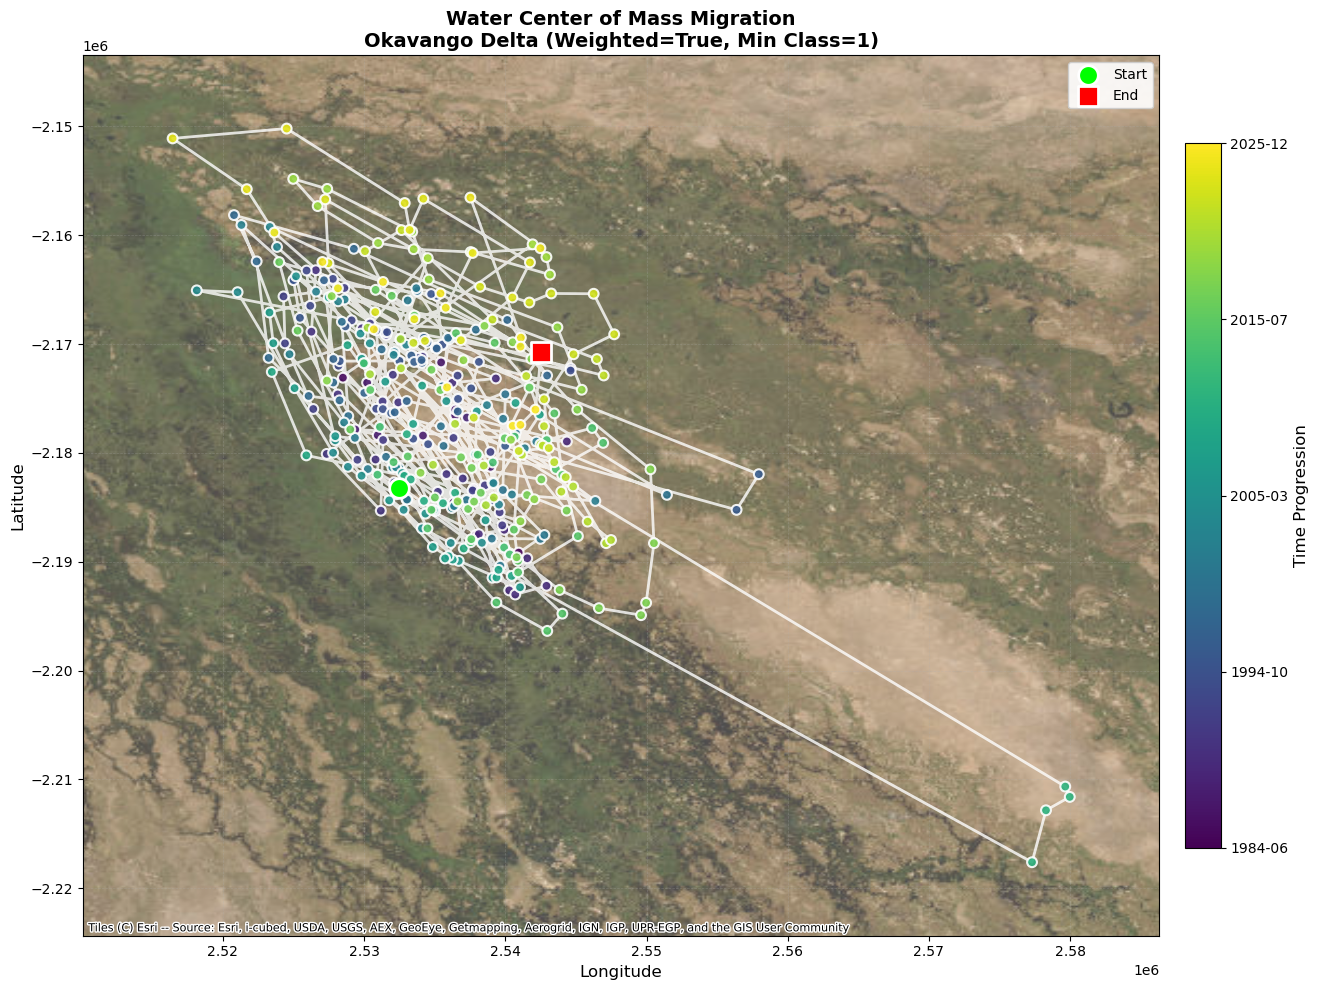


Running Example 2: Binary center of mass, high confidence only
Found 378 assets in projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products
Configuration: weighted=False, lowest_DSWE_class=3
------------------------------------------------------------
Processing 1984-06... ✓ Centroid: (22.7706, -19.2963), Area: 3495.3 km²
Processing 1984-07... ✓ Centroid: (22.7804, -19.3108), Area: 3597.4 km²
Processing 1984-09... ✓ Centroid: (22.9441, -19.4509), Area: 1548.4 km²
Processing 1984-10... ✓ Centroid: (22.8585, -19.4184), Area: 1219.0 km²
Processing 1984-11... ✓ Centroid: (22.8065, -19.3367), Area: 997.2 km²
Processing 1985-04... ✓ Centroid: (22.7421, -19.2029), Area: 920.3 km²
Processing 1986-11... ✓ Centroid: (22.8902, -19.3047), Area: 514.7 km²
Processing 1986-12... ✓ Centroid: (22.7700, -19.1310), Area: 369.0 km²
Processing 1987-01... ✓ Centroid: (22.7071, -19.0638), Area: 283.0 km²
Processing 1987-02... ✓ Centroid: (22.7131, -19.0350), Area: 289.7 km²
Processi

Processing 1998-05... ✓ Centroid: (22.5438, -19.0451), Area: 906.1 km²
Processing 1998-06... ✓ Centroid: (22.7036, -19.2464), Area: 1322.3 km²
Processing 1998-07... ✓ Centroid: (22.7348, -19.2778), Area: 1356.8 km²
Processing 1998-08... ✓ Centroid: (22.7739, -19.2897), Area: 1055.4 km²
Processing 1998-09... ✓ Centroid: (22.7672, -19.2706), Area: 713.1 km²
Processing 1998-10... ✓ Centroid: (22.8026, -19.1618), Area: 207.6 km²
Processing 1998-11... ✓ Centroid: (22.9323, -19.1677), Area: 214.0 km²
Processing 1998-12... ✓ Centroid: (22.8592, -19.2664), Area: 377.2 km²
Processing 1999-01... ✓ Centroid: (22.7578, -19.0867), Area: 339.4 km²
Processing 1999-02... ✓ Centroid: (22.6117, -18.9257), Area: 310.1 km²
Processing 1999-03... ✓ Centroid: (22.5975, -18.9226), Area: 324.9 km²
Processing 1999-04... ✓ Centroid: (22.5302, -18.8911), Area: 369.7 km²
Processing 1999-05... ✓ Centroid: (22.7189, -19.1343), Area: 373.5 km²
Processing 1999-06... ✓ Centroid: (22.7421, -19.2968), Area: 1187.9 km²
Pr

Processing 2013-03... ✓ Centroid: (22.6226, -19.1182), Area: 1191.7 km²
Processing 2013-04... ✓ Centroid: (22.6227, -19.1182), Area: 1191.7 km²
Processing 2013-05... ✓ Centroid: (22.7097, -19.2388), Area: 1791.2 km²
Processing 2013-06... ✓ Centroid: (22.7864, -19.3311), Area: 2039.1 km²
Processing 2013-07... ✓ Centroid: (22.8583, -19.4025), Area: 1887.2 km²
Processing 2013-08... ✓ Centroid: (22.9105, -19.4322), Area: 1501.1 km²
Processing 2013-09... ✓ Centroid: (22.9108, -19.4360), Area: 1185.8 km²
Processing 2013-10... ✓ Centroid: (22.8518, -19.2954), Area: 498.6 km²
Processing 2013-11... ✓ Centroid: (22.9144, -19.2812), Area: 320.9 km²
Processing 2013-12... ✓ Centroid: (22.9462, -19.2250), Area: 536.2 km²
Processing 2014-01... ✓ Centroid: (22.9295, -19.2485), Area: 1154.2 km²
Processing 2014-02... ✓ Centroid: (22.9196, -19.2563), Area: 1052.6 km²
Processing 2014-03... ✓ Centroid: (22.8502, -19.2603), Area: 1760.2 km²
Processing 2014-04... ✓ Centroid: (22.7233, -19.2027), Area: 2097.5

Processing 2022-10... ✓ Centroid: (22.9889, -19.2934), Area: 311.1 km²
Processing 2022-11... ✓ Centroid: (22.9594, -19.1746), Area: 216.1 km²
Processing 2022-12... ✓ Centroid: (22.9294, -19.1277), Area: 182.0 km²
Processing 2023-01... ✓ Centroid: (22.8355, -19.0227), Area: 175.1 km²
Processing 2023-02... ✓ Centroid: (22.6047, -18.8772), Area: 356.5 km²
Processing 2023-03... ✓ Centroid: (22.6465, -18.9514), Area: 312.0 km²
Processing 2023-04... ✓ Centroid: (22.6110, -18.9522), Area: 456.0 km²
Processing 2023-05... ✓ Centroid: (22.4774, -18.8864), Area: 934.5 km²
Processing 2023-06... ✓ Centroid: (22.6572, -19.0817), Area: 1257.3 km²
Processing 2023-07... ✓ Centroid: (22.7649, -19.1840), Area: 1311.8 km²
Processing 2023-08... ✓ Centroid: (22.8134, -19.2144), Area: 1131.4 km²
Processing 2023-09... ✓ Centroid: (22.8545, -19.2180), Area: 801.9 km²
Processing 2023-10... ✓ Centroid: (22.9521, -19.1487), Area: 234.6 km²
Processing 2023-11... ✓ Centroid: (22.9177, -19.0986), Area: 150.4 km²
Pro

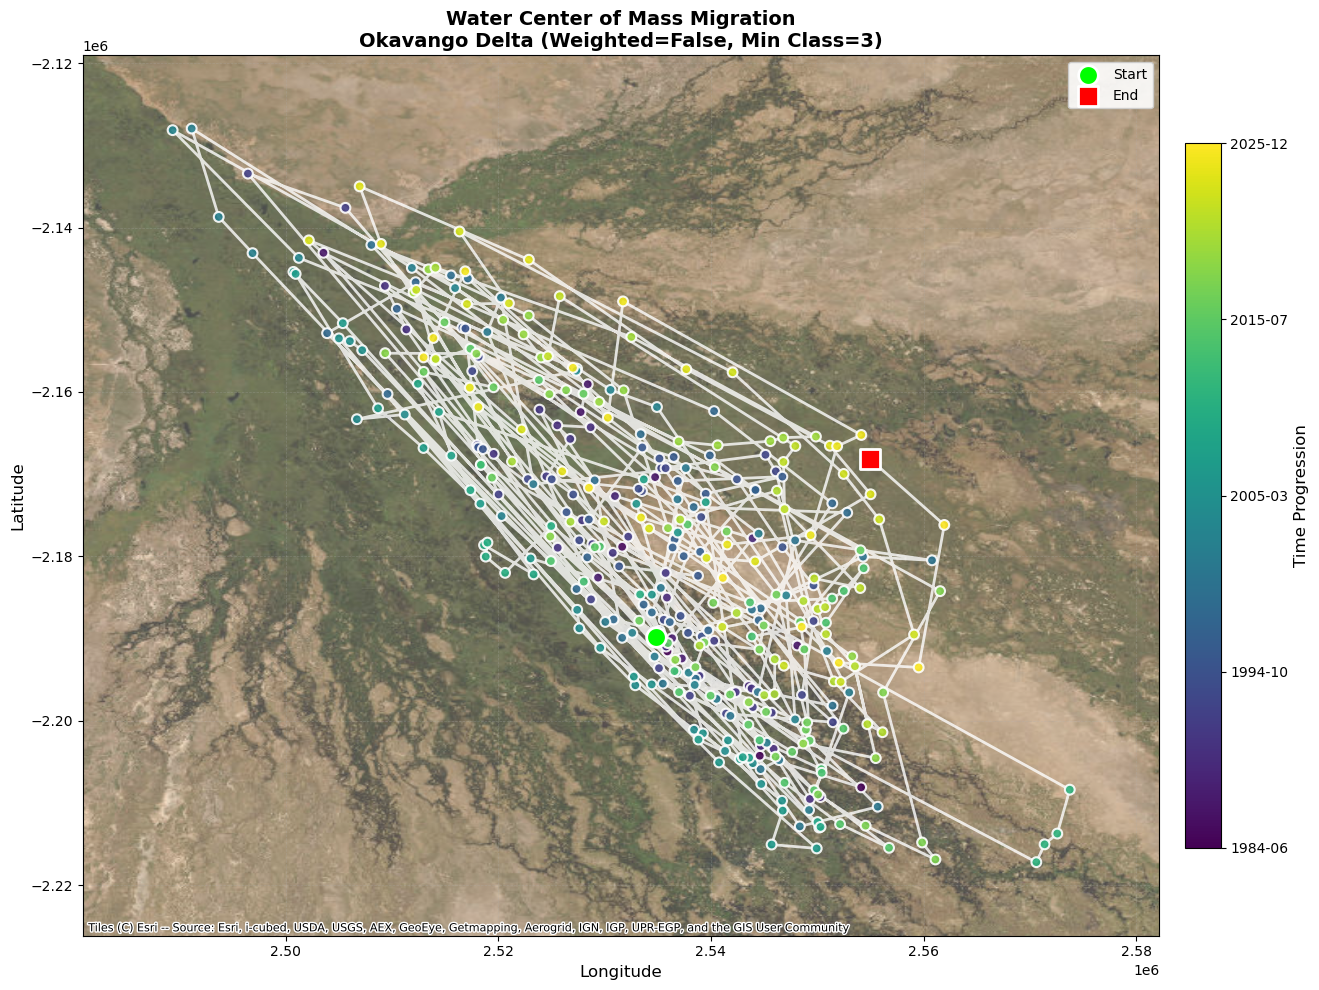


Running Example 3: Weighted center of mass, classes 2+
Found 378 assets in projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products
Configuration: weighted=True, lowest_DSWE_class=2
------------------------------------------------------------
Processing 1984-06... ✓ Centroid: (22.7424, -19.2454), Area: 6753.6 km²
Processing 1984-07... ✓ Centroid: (22.7471, -19.2551), Area: 6831.3 km²
Processing 1984-09... ✓ Centroid: (22.8412, -19.3161), Area: 4802.9 km²
Processing 1984-10... ✓ Centroid: (22.8033, -19.2992), Area: 4450.3 km²
Processing 1984-11... ✓ Centroid: (22.7803, -19.2638), Area: 4230.6 km²
Processing 1985-04... ✓ Centroid: (22.7222, -19.1675), Area: 3707.7 km²
Processing 1986-11... ✓ Centroid: (22.8128, -19.2326), Area: 3420.1 km²
Processing 1986-12... ✓ Centroid: (22.7723, -19.1675), Area: 3346.1 km²
Processing 1987-01... ✓ Centroid: (22.7588, -19.1475), Area: 2988.6 km²
Processing 1987-02... ✓ Centroid: (22.7641, -19.1232), Area: 3010.1 km²
Processing 

Processing 1998-05... ✓ Centroid: (22.5984, -19.0249), Area: 2729.7 km²
Processing 1998-06... ✓ Centroid: (22.6510, -19.1419), Area: 3257.0 km²
Processing 1998-07... ✓ Centroid: (22.6870, -19.1866), Area: 2920.5 km²
Processing 1998-08... ✓ Centroid: (22.7115, -19.1904), Area: 2763.5 km²
Processing 1998-09... ✓ Centroid: (22.7088, -19.1772), Area: 2316.5 km²
Processing 1998-10... ✓ Centroid: (22.7841, -19.1646), Area: 1120.4 km²
Processing 1998-11... ✓ Centroid: (22.8609, -19.1570), Area: 1239.5 km²
Processing 1998-12... ✓ Centroid: (22.8303, -19.1987), Area: 1679.5 km²
Processing 1999-01... ✓ Centroid: (22.7786, -19.1074), Area: 1929.7 km²
Processing 1999-02... ✓ Centroid: (22.7378, -19.0478), Area: 2313.4 km²
Processing 1999-03... ✓ Centroid: (22.8048, -19.0914), Area: 2678.1 km²
Processing 1999-04... ✓ Centroid: (22.7785, -19.0821), Area: 2676.4 km²
Processing 1999-05... ✓ Centroid: (22.7027, -19.0917), Area: 2279.5 km²
Processing 1999-06... ✓ Centroid: (22.7060, -19.2024), Area: 299

Processing 2011-03... ✓ Centroid: (23.1660, -19.4638), Area: 2265.0 km²
Processing 2013-03... ✓ Centroid: (22.6814, -19.1246), Area: 3434.8 km²
Processing 2013-04... ✓ Centroid: (22.6814, -19.1246), Area: 3434.7 km²
Processing 2013-05... ✓ Centroid: (22.6962, -19.1871), Area: 3725.1 km²
Processing 2013-06... ✓ Centroid: (22.7340, -19.2470), Area: 4130.2 km²
Processing 2013-07... ✓ Centroid: (22.8096, -19.3232), Area: 3734.8 km²
Processing 2013-08... ✓ Centroid: (22.8279, -19.3219), Area: 3626.4 km²
Processing 2013-09... ✓ Centroid: (22.8407, -19.3340), Area: 3105.0 km²
Processing 2013-10... ✓ Centroid: (22.8180, -19.2347), Area: 2063.5 km²
Processing 2013-11... ✓ Centroid: (22.8619, -19.2276), Area: 1473.4 km²
Processing 2013-12... ✓ Centroid: (22.7941, -19.1547), Area: 2085.5 km²
Processing 2014-01... ✓ Centroid: (22.8735, -19.1909), Area: 3523.2 km²
Processing 2014-02... ✓ Centroid: (22.8727, -19.1974), Area: 3759.2 km²
Processing 2014-03... ✓ Centroid: (22.8469, -19.2213), Area: 480

Processing 2022-08... ✓ Centroid: (22.8428, -19.2484), Area: 3142.3 km²
Processing 2022-09... ✓ Centroid: (22.8815, -19.2584), Area: 2304.0 km²
Processing 2022-10... ✓ Centroid: (22.8596, -19.2027), Area: 1612.2 km²
Processing 2022-11... ✓ Centroid: (22.9274, -19.1707), Area: 1039.5 km²
Processing 2022-12... ✓ Centroid: (22.9412, -19.1339), Area: 1026.9 km²
Processing 2023-01... ✓ Centroid: (22.8971, -19.0571), Area: 899.3 km²
Processing 2023-02... ✓ Centroid: (22.7835, -18.9915), Area: 1400.2 km²
Processing 2023-03... ✓ Centroid: (22.7370, -18.9872), Area: 1584.3 km²
Processing 2023-04... ✓ Centroid: (22.6644, -18.9707), Area: 1926.1 km²
Processing 2023-05... ✓ Centroid: (22.5722, -18.9327), Area: 2169.5 km²
Processing 2023-06... ✓ Centroid: (22.6432, -19.0344), Area: 2576.6 km²
Processing 2023-07... ✓ Centroid: (22.7236, -19.1209), Area: 2551.2 km²
Processing 2023-08... ✓ Centroid: (22.7845, -19.1595), Area: 2229.6 km²
Processing 2023-09... ✓ Centroid: (22.8184, -19.1593), Area: 2033

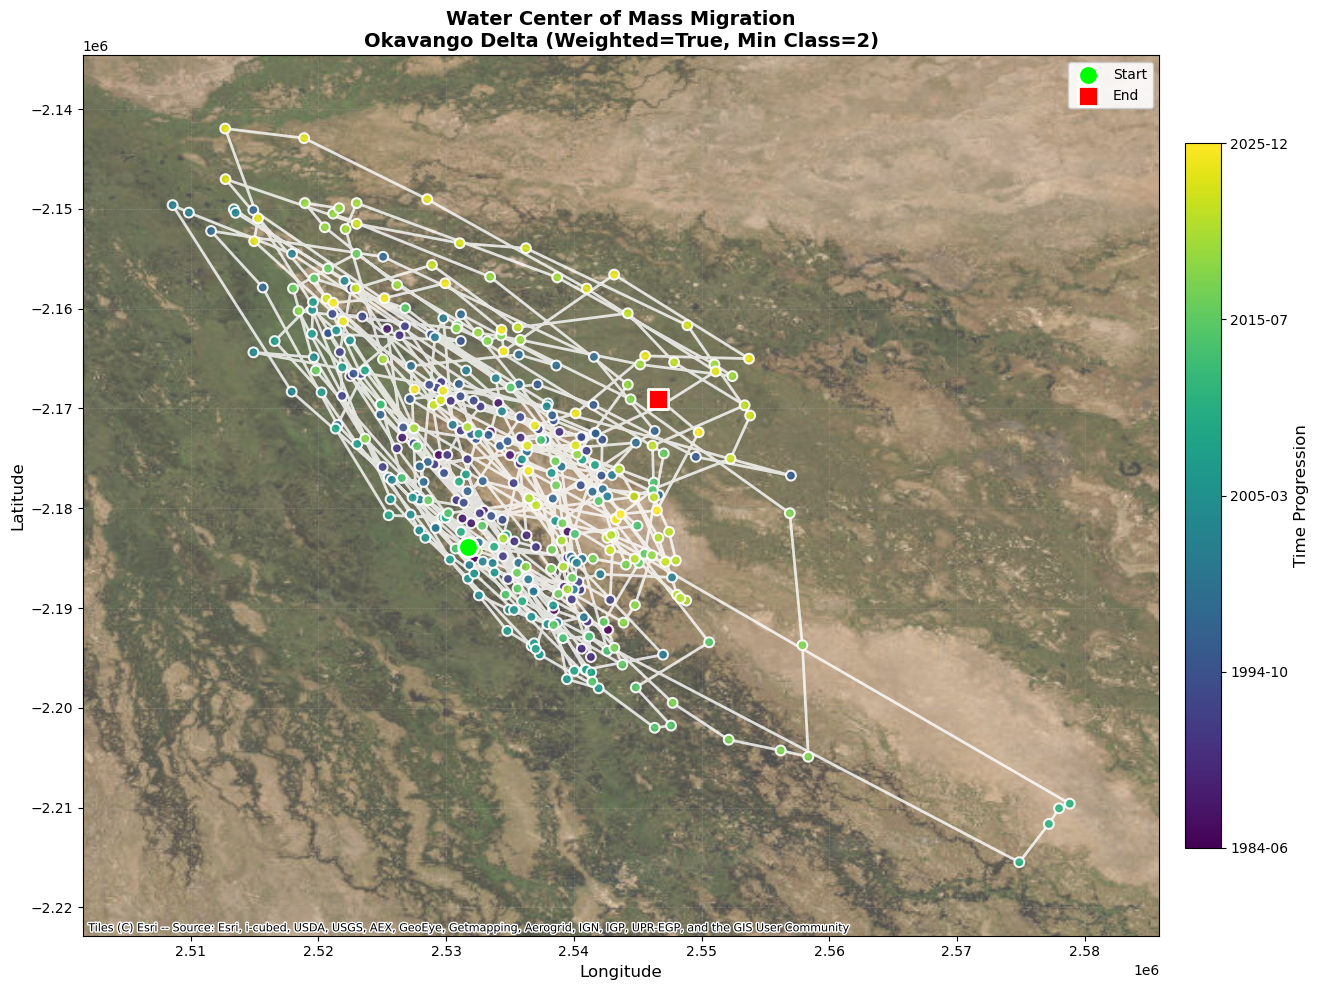

In [5]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import contextily as ctx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def calculate_water_centroid_timeseries(asset_folder, weighted=True, lowest_DSWE_class=1):
    """
    Calculate center of mass for all monthly DSWE products.
    
    Parameters:
    -----------
    asset_folder : str
        GEE folder path containing DSWE products
    weighted : bool
        If True, weight by DSWE confidence values; if False, binary (all water pixels equal)
    lowest_DSWE_class : int
        Minimum DSWE class to consider as water (1-4)
    
    Returns:
    --------
    pd.DataFrame
        Time series with columns: year, month, date, longitude, latitude, 
        total_water_area_km2, n_water_pixels, weighted, lowest_class
    """
    
    # Get list of all assets in folder
    asset_list = ee.data.listAssets({'parent': asset_folder})['assets']
    
    print(f"Found {len(asset_list)} assets in {asset_folder}")
    print(f"Configuration: weighted={weighted}, lowest_DSWE_class={lowest_DSWE_class}")
    print("-" * 60)
    
    results = []
    
    for asset in asset_list:
        asset_id = asset['name']
        
        # Extract year and month from asset name
        try:
            asset_name = asset_id.split('/')[-1]
            parts = asset_name.split('_')
            year = int(parts[1])
            month = int(parts[2])
            date_str = f"{year}-{month:02d}-01"
            
            print(f"Processing {year}-{month:02d}...", end=' ')
            
            # Load DSWE image
            img = ee.Image(asset_id).select('dswe')
            
            # Create water mask based on lowest_DSWE_class threshold
            water_mask = img.gte(lowest_DSWE_class)
            
            # Create weight image
            if weighted:
                # Use DSWE values as weights (1-4)
                weights = img.updateMask(water_mask)
            else:
                # Binary: all water pixels have weight of 1
                weights = water_mask.selfMask()
            
            # Get coordinate images
            coords = ee.Image.pixelLonLat()
            lon_img = coords.select('longitude')
            lat_img = coords.select('latitude')
            
            # Get pixel area for water area calculation
            pixel_area = ee.Image.pixelArea()
            
            # Calculate weighted sums
            weighted_lon = lon_img.multiply(weights)
            weighted_lat = lat_img.multiply(weights)
            
            # Reduce region to get sums
            reduction = ee.Image.cat([
                weighted_lon.rename('weighted_lon'),
                weighted_lat.rename('weighted_lat'),
                weights.rename('total_weight'),
                water_mask.multiply(pixel_area).rename('water_area'),
                water_mask.rename('pixel_count')
            ]).reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=img.geometry(),
                scale=30,
                maxPixels=1e9
            )
            
            # Get results
            result = reduction.getInfo()
            
            # Calculate centroid
            total_weight = result['total_weight']
            if total_weight and total_weight > 0:
                centroid_lon = result['weighted_lon'] / total_weight
                centroid_lat = result['weighted_lat'] / total_weight
                water_area_km2 = result['water_area'] / 1e6
                n_pixels = result['pixel_count']
                
                results.append({
                    'year': year,
                    'month': month,
                    'date': date_str,
                    'longitude': centroid_lon,
                    'latitude': centroid_lat,
                    'total_water_area_km2': water_area_km2,
                    'n_water_pixels': int(n_pixels),
                    'weighted': weighted,
                    'lowest_class': lowest_DSWE_class
                })
                
                print(f"✓ Centroid: ({centroid_lon:.4f}, {centroid_lat:.4f}), Area: {water_area_km2:.1f} km²")
            else:
                print(f"✗ No water detected")
                
        except Exception as e:
            print(f"✗ Error: {e}")
            continue
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)
    
    print("-" * 60)
    print(f"Successfully processed {len(df)} months with water detections")
    
    return df


def export_centroid_results(df, output_csv='centroid_timeseries.csv', 
                            output_plot='centroid_path.png', 
                            basemap_bounds=None,
                            figsize=(14, 10)):
    """
    Export centroid time series as CSV and visualization.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame from calculate_water_centroid_timeseries()
    output_csv : str
        Path for CSV export
    output_plot : str
        Path for plot image export
    basemap_bounds : list, optional
        [min_lon, min_lat, max_lon, max_lat] for basemap extent
        If None, automatically determined from data
    figsize : tuple
        Figure size (width, height) in inches
    
    Returns:
    --------
    None (saves files to disk)
    """
    
    # Export CSV
    df.to_csv(output_csv, index=False)
    print(f"CSV exported to: {output_csv}")
    
    # Prepare data for plotting
    if len(df) == 0:
        print("No data to plot!")
        return
    
    # Determine bounds
    if basemap_bounds is None:
        lon_buffer = (df['longitude'].max() - df['longitude'].min()) * 0.1
        lat_buffer = (df['latitude'].max() - df['latitude'].min()) * 0.1
        min_lon = df['longitude'].min() - lon_buffer
        max_lon = df['longitude'].max() + lon_buffer
        min_lat = df['latitude'].min() - lat_buffer
        max_lat = df['latitude'].max() + lat_buffer
    else:
        min_lon, min_lat, max_lon, max_lat = basemap_bounds
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Convert to Web Mercator for basemap
    df_plot = df.copy()
    # Using a simple approximation for Web Mercator
    from pyproj import Transformer
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    df_plot['x'], df_plot['y'] = transformer.transform(df_plot['longitude'].values, 
                                                        df_plot['latitude'].values)
    
    # Set extent in Web Mercator
    xmin, ymin = transformer.transform(min_lon, min_lat)
    xmax, ymax = transformer.transform(max_lon, max_lat)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # Add basemap
    try:
        ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, zoom=10, alpha=0.7)
        print("Basemap added successfully")
    except Exception as e:
        print(f"Warning: Could not add basemap: {e}")
        ax.set_facecolor('#E8E8E8')
    
    # Create color map based on time
    df_plot['time_numeric'] = (df_plot['date'] - df_plot['date'].min()).dt.days
    norm = Normalize(vmin=df_plot['time_numeric'].min(), vmax=df_plot['time_numeric'].max())
    cmap = plt.cm.viridis
    
    # Plot the path
    ax.plot(df_plot['x'], df_plot['y'], 
            linewidth=2, color='white', alpha=0.8, linestyle='-', zorder=2)
    
    # Plot points colored by time
    scatter = ax.scatter(df_plot['x'], df_plot['y'], 
                        c=df_plot['time_numeric'], 
                        cmap=cmap, norm=norm,
                        s=50, edgecolors='white', linewidth=1.5,
                        zorder=3, alpha=0.9)
    
    # Add start and end markers
    ax.scatter(df_plot.iloc[0]['x'], df_plot.iloc[0]['y'], 
              marker='o', s=200, color='lime', edgecolors='white', 
              linewidth=2, zorder=4, label='Start')
    ax.scatter(df_plot.iloc[-1]['x'], df_plot.iloc[-1]['y'], 
              marker='s', s=200, color='red', edgecolors='white', 
              linewidth=2, zorder=4, label='End')
    
    # Add colorbar
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax, 
                       orientation='vertical', pad=0.02, shrink=0.8)
    cbar.set_label('Time Progression', fontsize=12)
    
    # Format colorbar labels as dates
    n_ticks = 5
    tick_positions = np.linspace(df_plot['time_numeric'].min(), 
                                 df_plot['time_numeric'].max(), n_ticks)
    tick_dates = [df_plot['date'].min() + pd.Timedelta(days=int(pos)) 
                  for pos in tick_positions]
    cbar.set_ticks(tick_positions)
    cbar.set_ticklabels([d.strftime('%Y-%m') for d in tick_dates])
    
    # Labels and title
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    
    config_str = f"Weighted={df.iloc[0]['weighted']}, Min Class={df.iloc[0]['lowest_class']}"
    title = f'Water Center of Mass Migration\nOkavango Delta ({config_str})'
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
    
    # Add grid
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.savefig(output_plot, dpi=300, bbox_inches='tight')
    print(f"Plot exported to: {output_plot}")
    plt.show()


# Example usage
if __name__ == "__main__":
    # Initialize Earth Engine
    ee.Initialize()
    
    # Define asset folder
    asset_folder = "projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products"
    
    # Example 1: Default configuration (weighted, all water classes)
    print("=" * 60)
    print("Running Example 1: Weighted center of mass, all water classes")
    print("=" * 60)
    df_default = calculate_water_centroid_timeseries(
        asset_folder=asset_folder,
        weighted=True,
        lowest_DSWE_class=1
    )
    
    export_centroid_results(
        df=df_default,
        output_csv=r'D:\Okavango\Data\Inundation\Center_of_Mass\centroid_weighted_all.csv',
        output_plot=r'D:\Okavango\Data\Inundation\Center_of_Mass\centroid_weighted_all.png'
    )
    
    # Example 2: Binary, high confidence only
    print("\n" + "=" * 60)
    print("Running Example 2: Binary center of mass, high confidence only")
    print("=" * 60)
    df_binary_high = calculate_water_centroid_timeseries(
        asset_folder=asset_folder,
        weighted=False,
        lowest_DSWE_class=3
    )
    
    export_centroid_results(
        df=df_binary_high,
        output_csv=r'D:\Okavango\Data\Inundation\Center_of_Mass\centroid_binary_highconf.csv',
        output_plot=r'D:\Okavango\Data\Inundation\Center_of_Mass\centroid_binary_highconf.png'
    )
    
    # Example 3: Weighted, moderate-high confidence
    print("\n" + "=" * 60)
    print("Running Example 3: Weighted center of mass, classes 2+")
    print("=" * 60)
    df_weighted_mod = calculate_water_centroid_timeseries(
        asset_folder=asset_folder,
        weighted=True,
        lowest_DSWE_class=2
    )
    
    export_centroid_results(
        df=df_weighted_mod,
        output_csv=r'D:\Okavango\Data\Inundation\Center_of_Mass\centroid_weighted_moderate.csv',
        output_plot=r'D:\Okavango\Data\Inundation\Center_of_Mass\centroid_weighted_moderate.png'
    )